In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import matplotlib.pyplot as plt

from bliss.simulator.simulated_dataset import CachedSimulatedDataset, FileDatum
from bliss.surveys.des import DarkEnergySurvey, DESDownloader



from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

In [3]:
environ["CUDA_VISIBLE_DEVICES"] = "7"

In [4]:
#environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path="../", version_base=None):
    cfg = compose("config", {
        "encoder.tiles_to_crop=0",
        })

{'paths': {'root': '${oc.env:BLISS_HOME}', 'sdss': '/data/scratch/sdss', 'decals': '/data/scratch/decals', 'des': '/data/scratch/des', 'dc2': '/data/scratch/dc2local', 'output': '${paths.root}/output'}, 'prior': {'_target_': 'case_studies.galaxy_clustering.prior.GalaxyClusterPrior', 'survey_bands': ['u', 'g', 'r', 'i', 'z'], 'reference_band': 2, 'star_color_model_path': '${simulator.survey.dir_path}/color_models/star_gmm_nmgy.pkl', 'gal_color_model_path': '${simulator.survey.dir_path}/color_models/gal_gmm_nmgy.pkl', 'n_tiles_h': 56, 'n_tiles_w': 56, 'tile_slen': 64, 'batch_size': 1, 'max_sources': 6, 'mean_sources': 0.48, 'min_sources': 0, 'prob_galaxy': 0.2, 'star_flux_exponent': 0.9859821185389767, 'star_flux_truncation': 5685.588160703261, 'star_flux_loc': -1.162430157551662, 'star_flux_scale': 1.4137911256506595, 'galaxy_flux_truncation': 1013, 'galaxy_flux_exponent': 0.47, 'galaxy_flux_scale': 0.6301037, 'galaxy_flux_loc': 0.0, 'galaxy_a_concentration': 0.39330758068481686, 'galax

In [7]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
dataset = instantiate(cfg.cached_simulator)
trainer = instantiate(cfg.predict.trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
enc_output = trainer.predict(encoder, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 0it [00:00, ?it/s]

In [10]:
dataloader_iter = iter(dataset.predict_dataloader())

In [91]:
for i in range(len(dataloader_iter)):
    truth = next(dataloader_iter)
    outputs = enc_output[i]
    accuracy = (outputs["mode_cat"]["membership"][:,1:19,1:19].to(torch.bool) == truth["tile_catalog"]["membership"][:,1:19,1:19].to(torch.bool)).sum()
    print(accuracy/(3*18**2))
    break

tensor(0.9825)


In [127]:
def create_overlay(predictions, tile_size):
    overlay = torch.zeros((predictions.size(0) * tile_size, predictions.size(1) * tile_size, 3))
    detection_color = torch.tensor([0.0, 1.0, 0.0])  # Green color
    non_detection_color = torch.tensor([1.0, 0.0, 0.0])  # Red color
    for i in range(predictions.size(0)):
        for j in range(predictions.size(1)):
            color = detection_color if predictions[i, j] == 1 else non_detection_color
            overlay[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = color
    return overlay

def blend_images(original, overlay, alpha=0.5, img_crop=0):
    # Ensure the original image is in float
    if original.max() > 1.0:
        original = original / 255.0
    # Blend the images
    blended = original * (1 - alpha) + overlay * alpha
    blended = blended[img_crop: blended.size(0) - img_crop, img_crop: blended.size(1) - img_crop]
    print(blended.shape)
    return blended

def compute_metrics(est_cat, true_cat):
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    false_positives = (est_cat & ~true_cat).sum(dtype=torch.float32)
    false_negatives = (~est_cat & true_cat).sum(dtype=torch.float32)
    true_negatives = (~est_cat & ~true_cat).sum(dtype=torch.float32)

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives + 1e-6)  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), f1.item()
    

In [118]:
batch_id = 6
dataloader_iter = iter(dataset.predict_dataloader())
for i in range(batch_id):
    truth = next(dataloader_iter)
    outputs = enc_output[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1152, 1152, 3])
Image statistics:
 Accuracy:0.8753462433815002, 
 Precision: 0.21276596188545227,
 Recall: 0.555555522441864, 
 F1: 0.30769190192222595


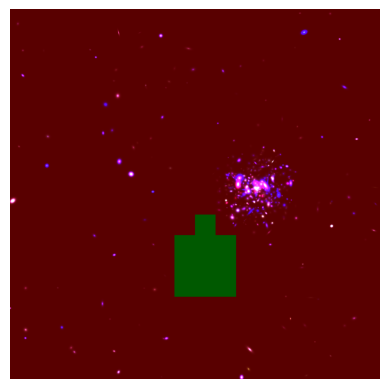

In [128]:

# img_id selects for an image within the batch, i.e., from 0 to batch_size - 1
img_id = 0
crop = 1
n_tiles = 20
tile_size = 64
img_size = 1280

band_idx = {
    "g": 0,
    "r": 1,
    "i": 2,
    "z": 3
}


est_cat = outputs["mode_cat"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)
true_cat = truth["tile_catalog"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)

img_acc, img_prec, img_rec, img_f1 =  compute_metrics(est_cat, true_cat)

test_img = truth["images"][img_id][[band_idx["g"], band_idx["r"], band_idx["z"]]]
test_out = outputs["mode_cat"]["membership"][img_id].squeeze()
overlay = create_overlay(test_out, tile_size=64)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=crop*tile_size)

print(f"Image statistics:\n Accuracy:{img_acc}, \n Precision: {img_prec},\n Recall: {img_rec}, \n F1: {img_f1}")
plt.imshow(blended_image)
plt.axis('off')
plt.show()

In [129]:
blended_image.shape

torch.Size([1152, 1152, 3])